# Assignment: Linear Models
## Do two questions in total: "Q1+Q2" or "Q1+Q3"
### `! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

Attached my work to Github file

**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2.1

In [20]:
cars_df = pd.read_csv("cars_hw.csv")
cars_df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [21]:
print(cars_df.info()) #Look at data
print(cars_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         976 non-null    int64 
 1   Make               976 non-null    object
 2   Make_Year          976 non-null    int64 
 3   Color              976 non-null    object
 4   Body_Type          976 non-null    object
 5   Mileage_Run        976 non-null    int64 
 6   No_of_Owners       976 non-null    object
 7   Seating_Capacity   976 non-null    int64 
 8   Fuel_Type          976 non-null    object
 9   Transmission       976 non-null    object
 10  Transmission_Type  976 non-null    object
 11  Price              976 non-null    int64 
dtypes: int64(5), object(7)
memory usage: 91.6+ KB
None
       Unnamed: 0    Make_Year   Mileage_Run  Seating_Capacity         Price
count  976.000000   976.000000    976.000000        976.000000  9.760000e+02
mean   488.500000  2016.963

In [22]:
cars_df = cars_df.dropna() #Dropped NA values

In [23]:
num_cols = cars_df.select_dtypes(include=[np.number]).columns #Identify numeric columns for transformation

for col in num_cols:
    if (cars_df[col] > 0).all():  #If all positive, safe for log
        skew = cars_df[col].skew()
        if abs(skew) > 1:  #only if highly skewed
            cars_df[col] = np.log1p(cars_df[col])  #log(1+x) to handle 0 safely
    else:
        # for columns that have 0 or negative values, use archsinh transformation
        cars_df[col] = np.arcsinh(cars_df[col])

In [24]:
Q1 = cars_df[num_cols].quantile(0.25) #Remove any outliers
Q3 = cars_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
cars_df = cars_df[~((cars_df[num_cols] < (Q1 - 1.5 * IQR)) | (cars_df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [25]:
print("After cleaning:") #Verify data has been cleaned
print(cars_df.describe())

After cleaning:
       Unnamed: 0    Make_Year   Mileage_Run  Seating_Capacity       Price
count  929.000000   929.000000    929.000000      9.290000e+02  929.000000
mean   487.641550  2016.970936  41272.260495      1.791759e+00   13.400150
std    281.333726     2.836837  24410.609139      2.221642e-16    0.447113
min      1.000000  2011.000000   1117.000000      1.791759e+00   12.375820
25%    247.000000  2015.000000  22538.000000      1.791759e+00   13.060490
50%    486.000000  2017.000000  37043.000000      1.791759e+00   13.398480
75%    732.000000  2019.000000  57046.000000      1.791759e+00   13.675100
max    976.000000  2022.000000  99495.000000      1.791759e+00   14.518113


2.2

In [26]:
descr = cars_df["Price"].describe() #Generate a summary for Price
print(descr, '\n')

count    929.000000
mean      13.400150
std        0.447113
min       12.375820
25%       13.060490
50%       13.398480
75%       13.675100
max       14.518113
Name: Price, dtype: float64 



<Axes: ylabel='Density'>

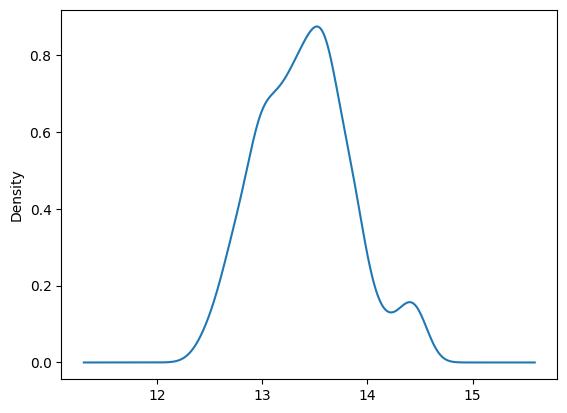

In [27]:
var = "Price"
cars_df[var].plot.density() #kernel_density plot

In [28]:
descriptions_by_make = cars_df.groupby("Make")["Price"].describe() #description of Price conditional on Make
descriptions_by_make

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,12.919898,0.480974,12.495008,12.568395,12.752289,13.171683,13.701223
Datsun,3.0,12.576050,0.036311,12.538971,12.558305,12.577640,12.594590,12.611541
Ford,52.0,13.468282,0.210894,12.577640,13.361382,13.469494,13.575985,13.879425
Honda,70.0,13.545564,0.341065,12.663501,13.271216,13.582317,13.736453,14.245344
Hyundai,305.0,13.368512,0.398781,12.421188,13.091906,13.366095,13.637581,14.370545
Jeep,4.0,14.216591,0.105084,14.070154,14.183271,14.240266,14.273587,14.315680
Kia,8.0,14.292178,0.076877,14.129592,14.272242,14.303106,14.349516,14.369971
MG Motors,34.0,14.442770,0.063446,14.278616,14.405918,14.429615,14.497597,14.518113
Mahindra,2.0,13.974858,0.120444,13.889691,13.932274,13.974858,14.017441,14.060025


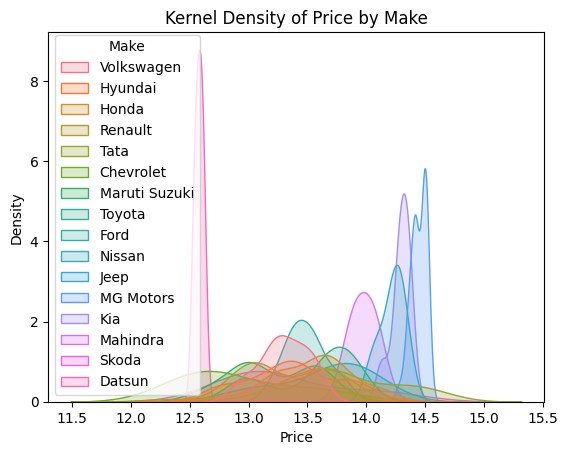

In [31]:
sns.kdeplot(data = cars_df, x = "Price", hue = "Make", fill = True, common_norm = False)

plt.title("Kernel Density of Price by Make")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

It looks like MG Motors is the most expensive car brand. In terms of general car prices, it seems to be in the middle of the graph, around 13.5.

2.3

In [33]:
from sklearn.model_selection import train_test_split #Split the sample
X = cars_df.loc[:, ["Price"]]
y = cars_df.loc[:, ["Make"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Price
398,12.904210
521,13.263865
101,13.134294
264,13.625561
208,13.398480
...,...
111,13.643536
285,13.286183
902,13.630386
454,12.546114


In [34]:
X_train

,Price
398,12.904210
521,13.263865
101,13.134294
264,13.625561
208,13.398480
...,...
111,13.643536
285,13.286183
902,13.630386
454,12.546114


In [35]:
X_test

,Price
792,13.575985
703,13.241037
32,13.030250
405,13.548939
202,13.909912
...,...
422,13.636385
5,13.311331
58,13.083625
379,13.503537


In [36]:
y_train

,Make
398,Volkswagen
521,Honda
101,Toyota
264,Maruti Suzuki
208,Hyundai
...,...
111,Honda
285,Hyundai
902,Maruti Suzuki
454,Maruti Suzuki


In [37]:
y_test

,Make
792,Ford
703,Honda
32,Renault
405,Hyundai
202,Hyundai
...,...
422,Hyundai
5,Hyundai
58,Maruti Suzuki
379,Ford


2.4

In [39]:
num_cols = cars_df.select_dtypes(include=[np.number]).columns.drop("Price") #Separate numerical and categorical columns
cat_cols = cars_df.select_dtypes(exclude=[np.number]).columns

In [40]:
X_train, X_test, y_train, y_test = train_test_split(cars_df.drop("Price", axis = 1), #Split into training/testing sets
                                                    cars_df["Price"],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X_train_num = X_train[num_cols] #Numeric model
X_test_num = X_test[num_cols]

model_num = LinearRegression()
model_num.fit(X_train_num, y_train)

y_pred_train_num = model_num.predict(X_train_num)
y_pred_test_num = model_num.predict(X_test_num)

r2_train_num = r2_score(y_train, y_pred_train_num)
r2_test_num = r2_score(y_test, y_pred_test_num)
rmse_train_num = np.sqrt(mean_squared_error(y_train, y_pred_train_num))
rmse_test_num = np.sqrt(mean_squared_error(y_test, y_pred_test_num))

print("Model 1: Numeric")
print(f"Train R²: {r2_train_num:.3f}, Test R²: {r2_test_num:.3f}")
print(f"Train RMSE: {rmse_train_num:.2f}, Test RMSE: {rmse_test_num:.2f}")

Model 1: Numeric
Train R²: 0.436, Test R²: 0.392
Train RMSE: 0.34, Test RMSE: 0.33


In [44]:
X_train_cat = pd.get_dummies(X_train[cat_cols], drop_first=True) #Categorical model
X_test_cat = pd.get_dummies(X_test[cat_cols], drop_first=True)

X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

model_cat = LinearRegression()
model_cat.fit(X_train_cat, y_train)

y_pred_test_cat = model_cat.predict(X_test_cat)

r2_test_cat = r2_score(y_test, y_pred_test_cat)
rmse_test_cat = np.sqrt(mean_squared_error(y_test, y_pred_test_cat))

print("Model 2: Categorical")
print(f"Test R²: {r2_test_cat:.3f}")
print(f"Test RMSE: {rmse_test_cat:.2f}")

Model 2: Categorical
Test R²: 0.597
Test RMSE: 0.27


In [45]:
X_train_full = pd.concat([X_train_num, X_train_cat], axis=1) #Combined numerical and categorical model
X_test_full = pd.concat([X_test_num, X_test_cat], axis=1)

model_full = LinearRegression()
model_full.fit(X_train_full, y_train)

y_pred_test_full = model_full.predict(X_test_full)

r2_test_full = r2_score(y_test, y_pred_test_full)
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))

print("Model 3: Combined Numeric + Categorical")
print(f"Test R²: {r2_test_full:.3f}")
print(f"Test RMSE: {rmse_test_full:.2f}")

Model 3: Combined Numeric + Categorical
Test R²: 0.792
Test RMSE: 0.19


In [46]:
print("Model Comparison (Test Set)") #Summarizing models
print(f"Numeric only:   R²={r2_test_num:.3f}, RMSE={rmse_test_num:.2f}")
print(f"Categorical only: R²={r2_test_cat:.3f}, RMSE={rmse_test_cat:.2f}")
print(f"Combined:       R²={r2_test_full:.3f}, RMSE={rmse_test_full:.2f}")

improvement = r2_test_full - max(r2_test_num, r2_test_cat)
print(f"Combined Model Improves R² by {improvement:.3f} Over the Best Single-Type Model")

Model Comparison (Test Set)
Numeric only:   R²=0.392, RMSE=0.33
Categorical only: R²=0.597, RMSE=0.27
Combined:       R²=0.792, RMSE=0.19
Combined Model Improves R² by 0.194 Over the Best Single-Type Model


2.5

In [48]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np

results = []

for d in range(1, 6):  #Try polynomial degrees 1–5
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_num)
    X_test_poly = poly.transform(X_test_num)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred_train = model.predict(X_train_poly)
    y_pred_test = model.predict(X_test_poly)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results.append({
        "Degree": d,
        "Train_R2": r2_train,
        "Test_R2": r2_test,
        "Train_RMSE": rmse_train,
        "Test_RMSE": rmse_test
    })

results_df = pd.DataFrame(results)
print(results_df)

   Degree  Train_R2   Test_R2  Train_RMSE  Test_RMSE
0       1  0.436419  0.392344    0.339795   0.329554
1       2  0.451929  0.413172    0.335087   0.323857
2       3  0.456866  0.419920    0.333574   0.321990
3       4  0.463568  0.422095    0.331510   0.321385
4       5  0.481515  0.423450    0.325917   0.321008


Training R^2 increases with the degree as the model gets more flexible. It seems as though Testing R^2 is a better fit when it first rises, but then it drops, which is indicative of overfitting. When the Testing R^2 is less than 0, the model is worse at predicting prices. On the testing set, RMSE also seems to increase after a certain degree.

2.6

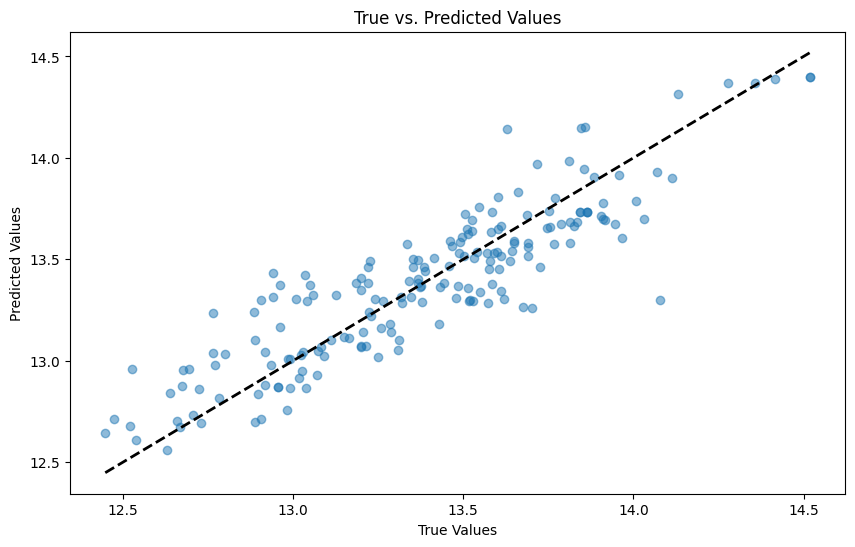

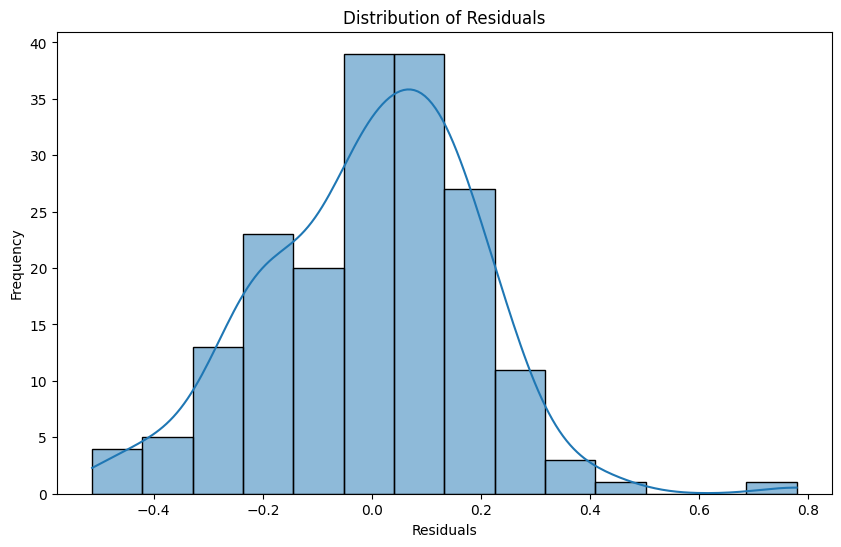

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model_full.predict(X_test_full) #Predict using your best model (assuming the combined model is the "best")

residuals = y_test - y_pred #Residuals (errors)

plt.figure(figsize=(10, 6)) #Plot true vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values")
plt.show()

plt.figure(figsize=(10, 6)) #Plot distribution of residuals
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

The residuals model is roughly bell-shaped and centered around 0, indicating that it is unbiased with random errors. The predicted vs. true price plot follows a consistent pattern, though the data is more widespread for more expensive cars. Overall, the model is good to get the overall picture of data patterns but not with outliers. Strengths of the model are that it is simple and understandable, and weaknesses of the model are that it cannot really capture effects that are not linear.

**Q3.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?

Chose not to do this one.